# **How trustworthy is your local representative?**

#### Data Sources:
politifact api documentation: http://static.politifact.com/api/v2apidoc.html <br>
govtrack api documentation: https://www.govtrack.us/developers/api <br>
propublica: https://projects.propublica.org/api-docs/congress-api/ <br>
congressional misconduct database: https://www.govtrack.us/misconduct <br>
news api: https://newsapi.org/docs <br>
votesmart: https://github.com/votesmart/python-votesmart/tree/master

## To do: April 15

1. Scrape truth-o-meter data ✅
2. Join truth-o-meter, misconduct db, and propublica ✅
3. Structure bills & votes **(in-progress)**
4. Incorporate news headlines
5. incorprate tweets (?)


In [1]:
# install Propublica congress api client module (from https://github.com/eyeseast/propublica-congress)
# ! pip3 install python-congress # <= uncomment this here

In [1]:
! pip install nbzip

google-api-python-client 1.5.3 has requirement uritemplate<1,>=0.6, but you'll have uritemplate 3.0.0 which is incompatible.
Could not install packages due to an EnvironmentError: [Errno 13] Permission denied: '/usr/local/lib/python3.5/dist-packages/nbzip-0.0.2.dist-info'
Consider using the `--user` option or check the permissions.



In [2]:
import requests

import json

import pandas as pd
import numpy as np
import datetime as dt

import matplotlib.pyplot as plt

from congress import Congress
propublica_key = 'wAxQ7sF8gcXCBRnY3lzegT23aljM4saALOb6JPlR'
congress = Congress(propublica_key)

from IPython.display import clear_output, display as clear, display

import os
import time
import ast

import requests
from lxml import html

% matplotlib inline

In [3]:
def open_json(file_name,folder='/data'):
    
    '''Read json'''
    
    if file_name[0] != '/':
        file_name = '/'+file_name
    if '.json' not in file_name:
        file_name = file_name+'.json'

    cwd = os.getcwd()

    if folder not in file_name:
        if cwd not in file_name:
            file_path = cwd+folder+file_name
        else:
            file_path = folder + file_name
    elif cwd not in file_name:
        file_path = cwd+file_name
    else:
        file_path = file_name
    file_path
    
    file = open(file_path,'r')
    res = json.load(file,)
    file.close()
    return res

## Get Politifact Data
politifact api documentation: http://static.politifact.com/api/v2apidoc.html  <br>
Markdown for `get_politifact.py` script below

```python    
import requests
import json
import os
import time
from IPython.display import clear_output as clear  # Remove in script

t0 = time.time()
t1 = t0

def get_politifact(limit,offset):
    """Scrape Politifact API"""
    pf_url = 'http://www.politifact.com/api/v/2/statement/'
    params = {
        'format' : 'json',
        'edition__edition_slug':'truth-o-meter',
        'limit' : limit,
        'offset' : offset,
        'order_by' : 'ruling_date'}
    resp = requests.get(pf_url,params=params).json()
    res = resp['objects']
    return res

folder = '/data'
file_name = '/politifact_test.json'
cwd = os.getcwd()
file_path = cwd+folder+file_name

if not os.path.isdir(cwd+folder):
    os.mkdir(cwd+folder)
    print('* New dir made: ',cwd+folder)
    
if not os.path.isfile(file_path):
    politifact_list = list()
    print('* New file made:',file_path)
    offset = 0
else:
    file = open(file_path,'r')
    politifact_list = json.load(file)
    file.close()
    offset = len(politifact_list) + 1

duplicate = 0
limit = 30
n = 0
nr = 0

print('#'*5, 'Scrape Politifact Script','#'*5)
print('Round:',nr)
print('List len:',len(politifact_list))
print('Duplicates:',duplicate)
print('Batch size:',limit)
print('*'*20)

while True:
    try:
        print('Iteration:',n)
        print('Start:',offset)

        batch = get_politifact(limit,offset) # api fetch

        if len(batch) == 0:
            print('#'*5,'Complete','#'*5)
            print(file_path)
            break

        for entry in batch:
            if entry in politifact_list:
                duplicate += 1
            elif entry not in politifact_list:
                politifact_list.append(entry)
        print('list len:',len(politifact_list))
        print('='*3)

        file = open(file_path, 'w')
        json.dump(politifact_list, file, ensure_ascii=False)
        file.close()
                        
        n+=1
        offset += limit
        if n % 5 == 0:
            timer0 = time.time()-t0
            timer1 = time.time()-t1
            t1 = time.time()

            os.system('clear')
            clear() # Remove in script
            print('#'*5, 'Scrape Politifact Script','#'*5)
            print('Round:',nr)
            print('Duplicates:',duplicate)
            print('Batch size:',limit)
            print('Round run time:',int(timer1/60),'m',round(timer1%60,2),'s')
            print('Total run time:',int(timer0/60),'m',round(timer0%60,2),'s')
            print('*'*20)
            nr += 1
    except:
        print('#'*5,'STOPPED','#'*5)
        print(file_path)
        break
file = open(file_path, 'w')
json.dump(politifact_list, file, ensure_ascii=False)
file.close()
```

## Cleaning Politifact

In [4]:
# upload to pandas this way to prevent memory error
pf = pd.DataFrame(open_json('politifact.json'))

pf.sort_values('statement_date',ascending=False,inplace=True)
pf.reset_index(inplace=True)

pf['statement_date'] = pd.to_datetime(pf['statement_date'])
pf['ruling_date'] = pd.to_datetime(pf['ruling_date'])
pf['statement'] = (pf['statement'].str.replace('<p>',"").str.replace('</p>','')
                   .str.replace('"','').str.replace('&quot;','')
                   .str.replace('\r','').str.replace('\n','').str.replace('&#39;','\''))
pf['ruling_comments'] = (pf['ruling_comments'].str.replace('<p>',"").str.replace('</p>','')
                   .str.replace('"','').str.replace('&quot;','')
                   .str.replace('\r','').str.replace('\n','').str.replace('&#39;','\''))

pf['ruling_slug'] = [ruling['ruling_slug'] for ruling in pf['ruling']]

pf['name_slug'] = [speaker['name_slug'] for speaker in pf['speaker']]
pf['home_state'] = [speaker['home_state'] for speaker in pf['speaker']]
pf['party'] = [speaker['party']['party_slug'] for speaker in pf['speaker']]
pf['first_name'] = [speaker['first_name'] for speaker in pf['speaker']]
pf['last_name'] = [speaker['last_name'] for speaker in pf['speaker']]

pf['statement_type'] = [statement['statement_type'] for statement in pf['statement_type']]

pf['subject_slug'] = [[subject['subject_slug'] for subject in subjects] for subjects in pf['subject']]

In [5]:
# Test to see that the cleaning method worked
sub = 'last_name'
main = 'speaker'
test_num = 10

import random
test = [random.randint(0,len(pf)) for i in range(test_num)]
for n in test:
    print(pf[sub].iloc[n] == pf.iloc[n][main][sub],'\t',pf[sub].iloc[n],pf.iloc[n][main][sub])

True 	 American Crossroads American Crossroads
True 	 Obama Obama
True 	 Republican Party of Florida Republican Party of Florida
True 	 Obama Obama
True 	 Spicer Spicer
True 	 Landrieu Landrieu
True 	 Moore Moore
True 	 Sessions Sessions
True 	 Brat Brat
True 	 Palin Palin


In [6]:
politifact = pf[['ruling_slug','first_name','last_name','name_slug',
                 'home_state','party','statement',
                 'subject_slug','ruling_comments','ruling_date',
                 'statement_context','statement_type','statement_date',
                 'twitter_headline','sources']]
politifact.head(3)

,ruling_slug,first_name,last_name,name_slug,home_state,party,statement,subject_slug,ruling_comments,ruling_date,statement_context,statement_type,statement_date,twitter_headline,sources
0,pants-fire,Donald,Trump,donald-trump,New York,republican,James Comey Memos just out and show clearly th...,"[crime, legal-issues]",President Donald Trump claimed that memos writ...,2018-04-20 13:33:46,in a tweet,Claim,2018-04-19,Trump falsely says Comey memos exonerate him,"<p><a href=""https://twitter.com/realDonaldTrum..."
1,half-true,Donald,Trump,donald-trump,New York,republican,The United States has a massive trade deficit ...,"[economy, foreign-policy, trade]",When President Donald Trump held a joint press...,2018-04-19 17:11:29,a press conference,Claim,2018-04-18,Is Donald Trump correct about the size of the ...,"<p>White House, <a href=""https://www.whitehous..."
2,barely-true,Charles,Schumer,charles-schumer,New York,democrat,"In the wake of the Republican-backed tax bill,...","[economy, jobs, taxes]","As Americans rushed to file their taxes, the D...",2018-04-18 17:34:40,a news release from Senate Democrats,Claim,2018-04-16,"Chuck Schumer, Senate Democrats flub statistic...","<p>Senate Democrats, &quot;<a href=""https://ww..."


In [7]:
len(politifact)

4835

# Govtrack (Deprecated)
govtrack api documentation: https://www.govtrack.us/developers/api <br>
still useful sometimes

In [8]:
# Data on legislators

person = 'https://www.govtrack.us/api/v2/person'
role = 'https://www.govtrack.us/api/v2/role'

params = {
    'current' : 'true'
}

resp = requests.get(person).json()

legis = pd.DataFrame(resp['objects'])
hillary = legis[legis['lastname']=='Clinton']['bioguideid'].iloc[0]

# Propublica
propublica: https://projects.propublica.org/api-docs/congress-api/  <br>
api client github: https://github.com/eyeseast/propublica-congress

In [9]:
# activate to install propublica congress library
# ! pip3 install python-congress

### 1. Congress Members

In [10]:
congress_meeting = 102 # Earliest congress is 80 for senate, 102 for house
congress_meeting = 115 # Latest is 115

def get_congress(congress_meeting=115):
    
    global bio_col,position_col,policy_col,other_col,congress_cols

    bio_col = ['first_name','last_name','middle_name','date_of_birth','id']
    position_col = ['title','party','seniority', # Seniority = years served
                     'state','district','state_rank','leadership_role',
                    'in_office','next_election']
    policy_col = ['dw_nominate','votes_with_party_pct','missed_votes_pct','missed_votes']
    other_col = ['chamber','gender','congress','twitter_account']

    congress_cols = bio_col+position_col+policy_col+other_col
    
    if congress_meeting >= 80: # Oldest Senate meeting on file
        sen = congress.members.filter('senate',congress = congress_meeting)
        for member in sen[0]['members']:
            member['congress'] = int(congress_meeting)
            member['district'] = np.nan
            member['chamber'] = 'Senate'
            for col in congress_cols:
                if col not in member.keys():
                    member[col] = np.nan
        senate = pd.DataFrame(sen[0]['members'])[congress_cols]
    else:
        senate = None
        
    if congress_meeting >= 102: # Oldest House meeting on file
        rep = congress.members.filter('house', congress = congress_meeting)
        for member in rep[0]['members']:
            member['congress'] = int(congress_meeting)
            member['state_rank'] = np.nan
            member['chamber'] = 'House'
            for col in congress_cols:
                if col not in member.keys():
                    member[col] = np.nan
        house = pd.DataFrame(rep[0]['members'])[congress_cols]
    else:
        house = None
    
    return senate, house

In [11]:
senate,house = get_congress()

In [12]:
pd.DataFrame(columns=congress_cols,index=[])

,first_name,last_name,middle_name,date_of_birth,id,title,party,seniority,state,district,...,in_office,next_election,dw_nominate,votes_with_party_pct,missed_votes_pct,missed_votes,chamber,gender,congress,twitter_account


In [13]:
members = pd.DataFrame(columns=congress_cols)
for meet in range(80,116):
    senate,house = get_congress(meet)
    df = senate.append(house)
    members = members.append(df).reset_index()[congress_cols]
    display(members.tail(1)[other_col+bio_col])

,chamber,gender,congress,twitter_account,first_name,last_name,middle_name,date_of_birth,id
101,Senate,M,80.0,None,Milton,Young,Ruben,1897-12-06,Y000047


,chamber,gender,congress,twitter_account,first_name,last_name,middle_name,date_of_birth,id
210,Senate,M,81.0,None,Milton,Young,Ruben,1897-12-06,Y000047


,chamber,gender,congress,twitter_account,first_name,last_name,middle_name,date_of_birth,id
315,Senate,M,82.0,None,Milton,Young,Ruben,1897-12-06,Y000047


,chamber,gender,congress,twitter_account,first_name,last_name,middle_name,date_of_birth,id
429,Senate,M,83.0,None,Milton,Young,Ruben,1897-12-06,Y000047


,chamber,gender,congress,twitter_account,first_name,last_name,middle_name,date_of_birth,id
532,Senate,M,84.0,None,Milton,Young,Ruben,1897-12-06,Y000047


,chamber,gender,congress,twitter_account,first_name,last_name,middle_name,date_of_birth,id
634,Senate,M,85.0,None,Milton,Young,Ruben,1897-12-06,Y000047


,chamber,gender,congress,twitter_account,first_name,last_name,middle_name,date_of_birth,id
740,Senate,M,86.0,None,Milton,Young,Ruben,1897-12-06,Y000047


,chamber,gender,congress,twitter_account,first_name,last_name,middle_name,date_of_birth,id
850,Senate,M,87.0,None,Milton,Young,Ruben,1897-12-06,Y000047


,chamber,gender,congress,twitter_account,first_name,last_name,middle_name,date_of_birth,id
958,Senate,M,88.0,None,Stephen,Young,Marvin,1889-05-04,Y000053


,chamber,gender,congress,twitter_account,first_name,last_name,middle_name,date_of_birth,id
1063,Senate,M,89.0,None,Stephen,Young,Marvin,1889-05-04,Y000053


,chamber,gender,congress,twitter_account,first_name,last_name,middle_name,date_of_birth,id
1167,Senate,M,90.0,None,Stephen,Young,Marvin,1889-05-04,Y000053


,chamber,gender,congress,twitter_account,first_name,last_name,middle_name,date_of_birth,id
1271,Senate,M,91.0,None,Stephen,Young,Marvin,1889-05-04,Y000053


,chamber,gender,congress,twitter_account,first_name,last_name,middle_name,date_of_birth,id
1376,Senate,M,92.0,None,Milton,Young,Ruben,1897-12-06,Y000047


,chamber,gender,congress,twitter_account,first_name,last_name,middle_name,date_of_birth,id
1483,Senate,M,93.0,None,Milton,Young,Ruben,1897-12-06,Y000047


,chamber,gender,congress,twitter_account,first_name,last_name,middle_name,date_of_birth,id
1591,Senate,M,94.0,None,Edward,Zorinsky,None,1928-11-11,Z000013


,chamber,gender,congress,twitter_account,first_name,last_name,middle_name,date_of_birth,id
1703,Senate,M,95.0,None,Edward,Zorinsky,None,1928-11-11,Z000013


,chamber,gender,congress,twitter_account,first_name,last_name,middle_name,date_of_birth,id
1806,Senate,M,96.0,None,Edward,Zorinsky,None,1928-11-11,Z000013


,chamber,gender,congress,twitter_account,first_name,last_name,middle_name,date_of_birth,id
1907,Senate,M,97.0,None,Edward,Zorinsky,None,1928-11-11,Z000013


,chamber,gender,congress,twitter_account,first_name,last_name,middle_name,date_of_birth,id
2009,Senate,M,98.0,None,Edward,Zorinsky,None,1928-11-11,Z000013


,chamber,gender,congress,twitter_account,first_name,last_name,middle_name,date_of_birth,id
2111,Senate,M,99.0,None,Edward,Zorinsky,None,1928-11-11,Z000013


,chamber,gender,congress,twitter_account,first_name,last_name,middle_name,date_of_birth,id
2212,Senate,M,100.0,None,Edward,Zorinsky,None,1928-11-11,Z000013


,chamber,gender,congress,twitter_account,first_name,last_name,middle_name,date_of_birth,id
2313,Senate,M,101.0,None,Timothy,Wirth,E.,1939-09-22,W000647


,chamber,gender,congress,twitter_account,first_name,last_name,middle_name,date_of_birth,id
2865,House,M,102.0,None,Richard,Zimmer,None,1944-08-16,Z000008


,chamber,gender,congress,twitter_account,first_name,last_name,middle_name,date_of_birth,id
3418,House,M,103.0,None,Richard,Zimmer,None,1944-08-16,Z000008


,chamber,gender,congress,twitter_account,first_name,last_name,middle_name,date_of_birth,id
3974,House,M,104.0,None,Richard,Zimmer,None,1944-08-16,Z000008


,chamber,gender,congress,twitter_account,first_name,last_name,middle_name,date_of_birth,id
4524,House,M,105.0,RepDonYoung,Don,Young,None,1933-06-09,Y000033


,chamber,gender,congress,twitter_account,first_name,last_name,middle_name,date_of_birth,id
5071,House,M,106.0,RepDonYoung,Don,Young,None,1933-06-09,Y000033


,chamber,gender,congress,twitter_account,first_name,last_name,middle_name,date_of_birth,id
5624,House,M,107.0,RepDonYoung,Don,Young,None,1933-06-09,Y000033


,chamber,gender,congress,twitter_account,first_name,last_name,middle_name,date_of_birth,id
6170,House,M,108.0,None,C. W. Bill,Young,None,1930-12-16,Y000031


,chamber,gender,congress,twitter_account,first_name,last_name,middle_name,date_of_birth,id
6717,House,M,109.0,None,C. W. Bill,Young,None,1930-12-16,Y000031


,chamber,gender,congress,twitter_account,first_name,last_name,middle_name,date_of_birth,id
7272,House,M,110.0,RepDonYoung,Don,Young,None,1933-06-09,Y000033


,chamber,gender,congress,twitter_account,first_name,last_name,middle_name,date_of_birth,id
7835,House,M,111.0,RepDonYoung,Don,Young,None,1933-06-09,Y000033


,chamber,gender,congress,twitter_account,first_name,last_name,middle_name,date_of_birth,id
8388,House,M,112.0,RepDonYoung,Don,Young,None,1933-06-09,Y000033


,chamber,gender,congress,twitter_account,first_name,last_name,middle_name,date_of_birth,id
8943,House,M,113.0,RepDonYoung,Don,Young,None,1933-06-09,Y000033


,chamber,gender,congress,twitter_account,first_name,last_name,middle_name,date_of_birth,id
9491,House,M,114.0,RepRyanZinke,Ryan,Zinke,None,1961-11-01,Z000018


,chamber,gender,congress,twitter_account,first_name,last_name,middle_name,date_of_birth,id
10043,House,M,115.0,RepRyanZinke,Ryan,Zinke,None,1961-11-01,Z000018


### Creating Foreign Key for Propublica and Politifact

In [14]:
def senate_pf(senate,politifact=politifact):
    
    '''Connecting Senate to Politifact with name slug'''
    
    senate['name_slug'] = senate['first_name'].str.lower() + '-' + senate['last_name'].str.lower()

    filter1 = senate[~senate['name_slug'].isin(politifact['name_slug'])]
    filter2 = filter1[filter1['last_name'].isin(politifact['last_name'])]
    sen_not_pf = filter1[~filter1['last_name'].isin(politifact['last_name'])]

    new_slugs = list()

    for i in range(len(filter2)):
        name = ['first_name','last_name']
        col = 'last_name'
        query = filter2['last_name'].iloc[i]
        result = politifact[politifact[col] == query]
        slug = result['name_slug'].iloc[0]

        new_slugs.append(slug)
        '''
        print(filter2[name].iloc[i])
        display(result[name])
        print(slug)
        print('='*30)
        '''

    new_slugs = [slug if slug != 'joe-kennedy' else 'john-kennedy' for slug in new_slugs]
    new_slugs = [slug if slug != 'mark-udall' else 'tom-udall' for slug in new_slugs]

    # Change name slugs
    filter2.loc[:,'name_slug'] = new_slugs
    old, new = [],[]
    for index in filter2.index:
        condition = senate.loc[index]['name_slug'] == filter2.loc[index]['name_slug']
        if not condition:
            old.append(senate.loc[index]['name_slug'])
            senate.loc[index,'name_slug'] = filter2.loc[index]['name_slug']
            new.append(senate.loc[index]['name_slug'])
    display(pd.DataFrame({'old':old,'new':new})[['old','new']])
    return senate

In [15]:
def house_pf(house,politifact=politifact):
    '''Connecting house to Politifact with name_slug'''
    
    house['name_slug'] = house['first_name'].str.lower() + '-' + house['last_name'].str.lower()

    filter1 = house[~house['name_slug'].isin(politifact['name_slug'])]
    filter2 = filter1[filter1['last_name'].isin(politifact['last_name'])]
    rep_not_pf = filter1[~filter1['last_name'].isin(politifact['last_name'])]

    new_slugs = list()
    count = 0
    for i in range(len(filter2)):
        name = ['first_name','last_name']
        col = 'last_name'

        match = filter2['last_name'].iloc[i]

        result = politifact[politifact[col] == match]

        nf = 2
        result = result[result['first_name'].str[:nf] == filter2['first_name'].str[:nf].iloc[i]]

        if len(result) > 0:
            slug = result['name_slug'].iloc[0]
            new_slugs.append(slug)
            count += 1
            '''
            print('#new slug appended#')
            print(filter2[name].iloc[i])
            display(result[name])
            print('slug:',slug)
            print('='*30)
            '''
        else:
            slug = filter2['name_slug'].iloc[i]
            new_slugs.append(slug)

    # Change name slugs
    filter2.loc[:,'name_slug'] = new_slugs
    old, new = [],[]
    for index in filter2.index:
        condition = house.loc[index]['name_slug'] == filter2.loc[index]['name_slug']
        if not condition:
            old.append(house.loc[index]['name_slug'])
            house.loc[index,'name_slug'] = filter2.loc[index]['name_slug']
            new.append(house.loc[index]['name_slug'])
    display(pd.DataFrame({'old':old,'new':new})[['old','new']])
    return house

In [16]:
senate, house = get_congress(115)

In [17]:
senate = senate_pf(senate)

/usr/local/lib/python3.5/dist-packages/pandas/core/indexing.py:465: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


,old,new
0,shelley-capito,shelley-moore-capito
1,benjamin-cardin,ben-cardin
2,christopher-coons,chris-coons
3,michael-enzi,mike-enzi
4,charles-grassley,chuck-grassley
5,christopher-murphy,chris-murphy
6,jim-risch,james-risch
7,bernard-sanders,bernie-s
8,patrick-toomey,pat-toomey
9,chris-van hollen,chris-van-hollen


In [18]:
house = house_pf(house)

/usr/local/lib/python3.5/dist-packages/pandas/core/indexing.py:465: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


,old,new
0,donald-beyer,don-beyer
1,david-brat,dave-brat
2,andré-carson,andre-carson
3,joaquín-castro,joaquin-castro
4,gerald-connolly,gerry-connolly
5,jeffrey-duncan,jeff-duncan
6,sheila-jackson lee,sheila-jackson-lee
7,eddie-johnson,eddie-bernice-johnson
8,joseph-kennedy,joe-kennedy
9,raúl-labrador,raul-labrador


In [19]:
house[house['name_slug']=='beto-orourke']

,first_name,last_name,middle_name,date_of_birth,id,title,party,seniority,state,district,...,next_election,dw_nominate,votes_with_party_pct,missed_votes_pct,missed_votes,chamber,gender,congress,twitter_account,name_slug
301,Beto,O'Rourke,None,1972-09-26,O000170,Representative,D,6,TX,16,...,2018,-0.319,92.04,1.98,17.0,House,M,115,RepBetoORourke,beto-orourke


In [20]:
print('congress:',congress_meeting)
path = os.getcwd()+'/data'
senate.to_json(path + '/senate_{congress_meeting}.json'.format(congress_meeting=congress_meeting))
house.to_json(path+'/house_{congress_meeting}.json'.format(congress_meeting=congress_meeting))

congress: 115


In [21]:
pd.DataFrame(
    {'Senate':senate.iloc[0],
     'House':house.iloc[0],
     'dtypes':house.dtypes})

,House,Senate,dtypes
first_name,Ralph,Lamar,object
last_name,Abraham,Alexander,object
middle_name,None,None,object
date_of_birth,1954-09-16,1940-07-03,object
id,A000374,A000360,object
title,Representative,"Senator, 2nd Class",object
party,R,R,object
seniority,4,15,object
state,LA,TN,object
district,5,NaN,object


## Connecting to SQL

In [22]:
from sqlalchemy import create_engine

pw = 'dwdstudent2015'

conn_string = 'mysql://{user}:{password}@{host}:{port}/?charset=utf8'.format(
    user     = 'root', 
    password = pw, 
    host     = '127.0.0.01', 
    port     = 3306, 
    encoding = 'utf-8'
)

clear_output()

engine = create_engine(conn_string)

In [23]:
db = 'congress'
engine.execute('CREATE DATABASE IF NOT EXISTS {db}'.format(db=db))

/usr/local/lib/python3.5/dist-packages/sqlalchemy/engine/default.py:450: Warning: Can't create database 'congress'; database exists
  cursor.execute(statement, parameters)


In [24]:
engine.execute('USE {db}'.format(db=db))
query='SHOW Databases'
display(pd.read_sql(query,con=engine))
query = 'SHOW Tables'
display(pd.read_sql(query,con=engine))

,Database
0,information_schema
1,citibike
2,congress
3,congressional_misconduct
4,facebook
5,imdb
6,mydb
7,mysql
8,newsapi_mysql
9,performance_schema


,Tables_in_congress
0,senate_115


In [25]:
drop_table = 'senate'
engine.execute('DROP TABLE IF EXISTS {table}'.format(table = drop_table))

/usr/local/lib/python3.5/dist-packages/sqlalchemy/engine/default.py:450: Warning: Unknown table 'congress.senate'
  cursor.execute(statement, parameters)


In [26]:
len(senate['id'][0])

7

In [27]:
df = senate
sql_cols = senate.columns
table_name = 'senate_115'
primary_key = 'id(10)'

engine.execute('DROP TABLE IF EXISTS {table}'.format(table = table_name))
df[sql_cols].to_sql(name=table_name,
                    con=engine,
                    if_exists='replace',
                    index=False)

add_key_query = 'ALTER TABLE {table} ADD PRIMARY KEY({key})'.format(table=table_name,key=primary_key)
engine.execute(add_key_query)

In [28]:
cols = ['first_name','last_name','party','state','title','seniority']
senate[cols].tail()

,first_name,last_name,party,state,title,seniority
99,Elizabeth,Warren,D,MA,"Senator, 1st Class",5
100,Sheldon,Whitehouse,D,RI,"Senator, 1st Class",11
101,Roger,Wicker,R,MS,"Senator, 1st Class",11
102,Ron,Wyden,D,OR,"Senator, 3rd Class",22
103,Todd,Young,R,IN,"Senator, 3rd Class",1


In [29]:
select = ['first_name','last_name','party','state','title','seniority','id']
table_name = 'senate_115'
condition = 'WHERE last_name = "Warren"'

query = ('''SELECT {columns} FROM {table} {condition}'''
         .format(columns = ','.join(select),table=table_name,condition = condition))

display(pd.read_sql(query,con=engine))

,first_name,last_name,party,state,title,seniority,id
0,Elizabeth,Warren,D,MA,"Senator, 1st Class",5,W000817


### Merging Politifact, Propublica, and Congressional Misconduct DB
Use `get_misconduct.ipynb` to scrape data from govtrack misconduct database

```python
import requests
from lxml import html
import pandas as pd
import re
from IPython.display import display, clear_output

url = "https://www.govtrack.us/misconduct"
gt_url = 'https://www.govtrack.us'
response = requests.get(url)
doc = html.fromstring(response.text)

# Using Regex to get entry class names
html = requests.get(url).text
regex = re.compile(r'class="misconduct-entry.*"')
matches = regex.finditer(html)
calls = [m.group() for m in matches]
entries = [doc.xpath('//div[@{ent}]'.format(ent=call))[0] for call in calls]

def parseEntryNode(entry):

    member = entry.xpath('.//h3/a')[0].text_content().strip()
    member_page = gt_url+entry.xpath('.//h3/a')[0].get('href')
    tags = [tag.text_content().strip() for tag in entry.xpath('.//div[@class="tag-list"]')[0]]
    paragraph = entry.xpath('.//p')[0].text_content()
    updates = [' '.join(update.text_content().split()) for update in entry.xpath('.//table')[0]]
    update_links = [update.xpath('.//a')[0].get('href') if len(update.xpath('.//a')) > 0 else None for update in entry.xpath('.//table')[0]]
    
    result = {
    'member' : member,
    'member_page' : member_page,
    'tags' : tags,
    'paragraph' : paragraph,
    'updates' : updates,
    'update_links' : update_links
    }
    return result
    
contents = doc.xpath('//div[@class="col-sm-8 col-sm-pull-4"]')[0]

# Data contants starts from index 1
data = [parseEntryNode(contents[i]) for i in range(1,len(contents))] 
df = pd.DataFrame(data)
def get_bioguide(member_url):
    '''returns bioguide given govtrack member page'''
    member_html = requests.get(member_url).text
    bioregex = re.compile(r'href="http://bioguide.congress.gov/.*" ')
    res = bioregex.findall(member_html)[0]
    bioguide = res.replace('href="http://bioguide.congress.gov/scripts/biodisplay.pl?index=','')[:7]
    return bioguide
print('Getting bioguide...')
bioguide = [get_bioguide(url) for url in df['member_page']] # This step takes some time
df['bioguide'] = bioguide

# Print duplicates
print('Duplicate rows:', len(df[df['paragraph'].duplicated()]))

# Reverse entry_index for primary key
df['entry_index'] = len(df)-df.index

# Get names and districts of congress members using Regex raw string for member column
members_strings = df['member'].to_string()

# The district regex is imperfect because of irregularities
district_regex = re.compile(r'\[+\w-[\w]*')
district_matches = district_regex.finditer(members_strings)
rg_district = [m.group()[1:] for m in district_matches]

# Get names using regex
names_regex = re.compile(r"[A-z].*\[")
names_matches = names_regex.finditer(members_strings)
names = [m.group()[:-2] for m in names_matches]
df['member_name'] = names

# Get districts from names
district = [df['member'][i].replace(
    df['member_name'][i]+' ','')
            for i in range(len(df))]
df['district'] = district

# Member parties are denoted by 1 letter abbreviations before the district
print(set(df['district'].str[1:3]))

# Add column with full party name
party_dict = {'A':'A (Miscellaneous)','D':'Democrat','F':'Federalist',
         'I':'Independent','J':'Jackson','R':'Republican',
         'U' : 'Unconditional Unionist','W' :'Whig'}
member_party = [party_dict[df['district'].iloc[i][1]] for i in range(len(df))]
df['party'] = member_party

### SQL ###
print('uploading to SQL')

from sqlalchemy import create_engine
db = 'congressional_misconduct'
pw = 'dwdstudent2015'
conn_string = 'mysql://{user}:{password}@{host}:{port}/?charset=utf8'.format(
    user     = 'root', 
    password = pw, 
    host     = '127.0.0.01', 
    port     = 3306, 
    encoding = 'utf-8'
)
engine = create_engine(conn_string)
engine.execute('CREATE DATABASE IF NOT EXISTS {db}'.format(db=db))
print('Database:',db)

engine.execute('USE {db}'.format(db=db))
pd.read_sql('SHOW Databases',con=engine)

# Drop all existing tables
db_tables = pd.read_sql('SHOW TABLES',con=engine).iloc[:,0]
for t in db_tables:
    if t != 'misconduct_entries':
        engine.execute('DROP TABLE IF EXISTS {table}'.format(table = t))

# Drop table with foreign key reference last        
engine.execute('DROP TABLE IF EXISTS {table}'.format(table = 'misconduct_entries'))

df[['entry_index','member_name','bioguide','party','district',
    'member','member_page','paragraph']].to_sql(name='misconduct_entries',
                                                 con=engine,
                                                 if_exists='replace',
                                                 index=False)
add_key_query = 'ALTER TABLE misconduct_entries ADD PRIMARY KEY(entry_index)'
engine.execute(add_key_query)

# Create dataframe from iterated list
index_list = list()
tags_list = list()

for i in range(len(df)):
    for tag in df.iloc[i]['tags']:
        index_list.append(df.iloc[i]['entry_index']) # Use entry_index as foreign key
        tags_list.append(tag)
        
tags_df = pd.DataFrame({
    'entry_index' : index_list,
    'tags' : tags_list})
# Create table
tags_df.to_sql(name='misconduct_tags',con=engine,if_exists='replace',index=False)

# Create dataframe iterated list
index_list = list()
update_list = list()
link_list = list()

for i in range(len(df)):
    for update in df.iloc[i]['updates']:
        index_list.append(df.iloc[i]['entry_index'])
        update_list.append(update)
    for lnk in df.iloc[i]['update_links']:
        link_list.append(lnk)
        
updates_df = pd.DataFrame({
    'entry_index' : index_list,
    'updates' : update_list,
    'update_links' : link_list})

# Create table
updates_df.to_sql(name='timeline_update',con=engine,if_exists='replace',index=False)

# Add foreign keys
db_tables = pd.read_sql('SHOW TABLES',con=engine).iloc[:,0]

for t in db_tables:
    if t != 'misconduct_entries':
        add_key_query = '''ALTER TABLE {table} ADD FOREIGN KEY(entry_index) REFERENCES misconduct_entries(entry_index)'''.format(table=t)

        engine.execute(add_key_query)

print('### Complete ###')
```

In [30]:
# Get Misconduct
engine.execute('USE congressional_misconduct')

query = 'SELECT * FROM misconduct_entries'
misconduct = pd.read_sql(query,con=engine)
misconduct.rename(columns={'paragraph':'misconduct_descrp'},inplace=True)

In [31]:
query = 'SELECT * FROM misconduct_tags'
mc_tags = pd.read_sql(query,con=engine)

mc_tags_new = list()
for entry_index in mc_tags['entry_index']:
    entry = mc_tags[mc_tags['entry_index'] == entry_index]
    mc_tags_new.append({
        'entry_index':entry_index,
        'tags':[tag for tag in entry['tags']]
    })
mc_tags = pd.DataFrame(mc_tags_new)

In [32]:
pd.merge(misconduct,senate,how='inner',left_on='bioguide',right_on='id')

,entry_index,member_name,bioguide,party_x,district_x,member,member_page,misconduct_descrp,first_name,last_name,...,next_election,dw_nominate,votes_with_party_pct,missed_votes_pct,missed_votes,chamber,gender,congress,twitter_account,name_slug
0,370,Sen. Robert “Bob” Menéndez,M000639,Democrat,[D-NJ],Sen. Robert “Bob” Menéndez [D-NJ],https://www.govtrack.us/congress/members/rober...,Menendez is being investigated for unspecified...,Robert,Menendez,...,2018,-0.360,92.59,20.0,81,Senate,M,115,SenatorMenendez,robert-menendez
1,373,Sen. Alan “Al” Franken,F000457,Democrat,"[D-MN, 2009-2017]","Sen. Alan “Al” Franken [D-MN, 2009-2017]",https://www.govtrack.us/congress/members/alan_...,"On December 7, 2017, Senator Franken announced...",Al,Franken,...,2020,-0.397,97.44,4.0,13,Senate,M,115,SenFranken,al-franken


In [33]:
# Merge misconduct with senate
def merge_tables(df1,df2,left_on,right_on):

    complement = list(set(df1.columns) - set(df2.columns))
    col_df1 = list(set(complement+[left_on]))
    res = (pd.merge(df1[col_df1],df2,how='inner',
             left_on=left_on,right_on=right_on)
     [complement+bio_col+position_col])
    return res

In [34]:
df = merge_tables(misconduct,senate,'bioguide','id')
merge_tables(mc_tags,df,'entry_index','entry_index')

,tags,first_name,last_name,middle_name,date_of_birth,id,title,party,seniority,state,district,state_rank,leadership_role,in_office,next_election
0,"[sexual harassment & abuse, resignation, resol...",Al,Franken,None,1951-05-21,F000457,"Senator, 2nd Class",D,9,MN,NaN,junior,,False,2020
1,"[sexual harassment & abuse, resignation, resol...",Al,Franken,None,1951-05-21,F000457,"Senator, 2nd Class",D,9,MN,NaN,junior,,False,2020
2,"[sexual harassment & abuse, resignation, resol...",Al,Franken,None,1951-05-21,F000457,"Senator, 2nd Class",D,9,MN,NaN,junior,,False,2020
3,"[bribery & corruption, unresolved]",Robert,Menendez,None,1954-01-01,M000639,"Senator, 1st Class",D,12,NJ,NaN,senior,None,True,2018
4,"[bribery & corruption, unresolved]",Robert,Menendez,None,1954-01-01,M000639,"Senator, 1st Class",D,12,NJ,NaN,senior,None,True,2018


In [35]:
# Merge misconduct with house
pd.merge(misconduct,house[senate.columns[:12]]
         ,how='inner',left_on='bioguide',
         right_on='id').sort_values('bioguide').tail(3)

,entry_index,member_name,bioguide,party_x,district_x,member,member_page,misconduct_descrp,first_name,last_name,middle_name,date_of_birth,id,title,party_y,seniority,state,district_y,state_rank,leadership_role
48,362,Rep. Roger Williams,W000816,Republican,[R-TX25],Rep. Roger Williams [R-TX25],https://www.govtrack.us/congress/members/roger...,In 2017 Williams was investigated for improper...,Roger,Williams,None,1949-09-13,W000816,Representative,R,6,TX,25,NaN,None
18,325,Rep. Don Young,Y000033,Republican,[R-AK0],Rep. Don Young [R-AK0],https://www.govtrack.us/congress/members/don_y...,In 2014 Young received a letter of reproval fo...,Don,Young,None,1933-06-09,Y000033,Representative,R,46,AK,At-Large,NaN,None
17,305,Rep. Don Young,Y000033,Republican,[R-AK0],Rep. Don Young [R-AK0],https://www.govtrack.us/congress/members/don_y...,In 2011 Young was investigated for accepting c...,Don,Young,None,1933-06-09,Y000033,Representative,R,46,AK,At-Large,NaN,None


In [36]:
# Merge Senate and Misconduct
cols = list(set(politifact.columns)- set(senate.columns))
df = pd.merge(politifact[cols+['name_slug']],senate,
         how='inner',left_on='name_slug',right_on='name_slug')
df.sort_values('name_slug').tail(3)

,statement_type,statement_context,statement_date,statement,ruling_slug,sources,ruling_comments,twitter_headline,ruling_date,subject_slug,...,in_office,next_election,dw_nominate,votes_with_party_pct,missed_votes_pct,missed_votes,chamber,gender,congress,twitter_account
306,Claim,a letter to Iranian leaders,2015-03-09,If President Barack Obama strikes a nuclear de...,mostly-true,"<p><a href=""http://go.bloomberg.com/assets/con...",The Obama administration&rsquo;s efforts to ne...,,2015-03-11 12:01:36,"[foreign-policy, legal-issues]",...,True,2020,0.616,97.52,0.49,2,Senate,M,115,SenTomCotton
311,Claim,a television ad,2014-07-08,Says he voted for disaster relief and full fun...,half-true,"<p>Cotton for Senate, &quot;<a href=""http://ww...","Rep. Tom Cotton, R-Ark. -- engaged in a tough ...",,2014-07-09 15:26:12,"[candidates-biography, congress, federal-budge...",...,True,2020,0.616,97.52,0.49,2,Senate,M,115,SenTomCotton
308,Claim,a debate,2014-10-13,Says Mark Pryor votes with Obama 93 percent of...,mostly-true,"<p>C-SPAN, <a href=""http://www.c-span.org/vide...",Tom Cotton says Mark Pryor votes in lockstep w...,,2014-10-22 17:07:32,"[bipartisanship, voting-record]",...,True,2020,0.616,97.52,0.49,2,Senate,M,115,SenTomCotton


In [37]:
# Merge House and Misconduct
df = pd.merge(politifact,house,
         how='inner',left_on='name_slug',right_on='name_slug')
cols = df.columns[:len(politifact.columns)+10]
df[cols].sort_values('name_slug').tail(3)

,ruling_slug,first_name_x,last_name_x,name_slug,home_state,party_x,statement,subject_slug,ruling_comments,ruling_date,...,first_name_y,last_name_y,middle_name,date_of_birth,id,title,party_y,seniority,state,district
236,true,Xavier,Becerra,xavier-becerra,California,democrat,"\tWe've had 11,000 attempts to amend the Const...",[legal-issues],\tAt a <a href=http://www.dems.gov/press/democ...,2011-08-30 11:38:21,...,Xavier,Becerra,None,1958-01-26,B000287,Representative,D,26,CA,34
235,mostly-true,Xavier,Becerra,xavier-becerra,California,democrat,\tWe have a tax code that allows groups to use...,"[elections, taxes]",\tThe fallout from the Internal Revenue Servic...,2013-05-22 17:54:55,...,Xavier,Becerra,None,1958-01-26,B000287,Representative,D,26,CA,34
249,mostly-true,Zoe,Lofgren,zoe-lofgren,California,democrat,\tWith the exception of slavery and the Chines...,[immigration],\tRep. Zoe Lofgren says the United States has ...,2013-02-08 18:00:19,...,Zoe,Lofgren,None,1947-12-21,L000397,Representative,D,24,CA,19


# Getting Bills
https://projects.propublica.org/api-docs/congress-api/bills/

In [38]:
def bill_subject(bill_id):
    
    '''Gets list of bill subjects given bill_id'''
    
    bill_slug, congress_meeting = bill_id.split('-')
    bill = pd.DataFrame(congress.bills.subjects(bill_slug,congress=congress_meeting))['subjects']
    return [subject['url_name'] for subject in bill]


def add_bill_subjects(bills):
    
    '''add bill subjects to list of bill dictionaries'''
    from IPython.display import clear_output as clear
    
    print('Getting bill subjects...\n')
    n=0
    for bill in bills:
        bill_subjects = bill_subject(bill['bill_id'])
        bill['bill_subjects'] = bill_subjects

        print(len(bills)-n, 'bills left')
        n+=1
        if n%10 == 0:
            clear()
            print('Getting bill subjects...\n')
    clear()
    return bills

def get_bills(bioguide,bill_type = 'introduced',add_subjects=True):
    
    '''Scrapes all bills introduced or otherwise related to a member'''
    
    import requests
    import time
    from IPython.display import clear_output as clear
        
    PROPUBLICA_API_KEY = 'wAxQ7sF8gcXCBRnY3lzegT23aljM4saALOb6JPlR'

    propub_url = ('https://api.propublica.org/congress/v1/members/{m_id}/bills/{bill_type}.json'
                  .format(m_id=bioguide,bill_type=bill_type))
    header = {'X-API-Key' : PROPUBLICA_API_KEY}

    page=0
    res = list()
    while True:
        
        param = {'offset' : page*20}
        data = requests.get(propub_url,headers=header,params=param).json()

        sponsor_id = data['results'][0]['id']
        sponsor_name = data['results'][0]['name']

        res.extend(data['results'][0]['bills']) # res
        
        print('page:',page)
        print('bills in page:',len(data['results'][0]['bills']))
        print('offset:',data['results'][0]['offset'])

        if len(data['results'][0]['bills']) < 20:
            print('### Done ###')
            clear()
            break
        page +=1
        if page%3 == 0:
            clear()
        print('===')
    
    if len(res) == 0:
        return {
            'sponsor_id':sponsor_id,
            'sponsor_name':sponsor_name,
            'Message':['No Bills '+bill_type.title()]
        }
    elif len(res) > 0:

        if add_subjects:
            res = add_bill_subjects(res)
        return res


In [39]:
hillary # Hillary Clinton (many bills + retired senator)
smith = 'S001203' # Tina Smith (some bills)
lamb = 'L000588' # Connor Lamb (no bills)
warren = senate[senate['last_name'] == 'Warren']['id'].iloc[0] # Elizabeth Warren

In [40]:
bills = get_bills(warren)
pd.DataFrame(bills).tail(3)

,active,bill_id,bill_subjects,bill_type,bill_uri,committees,congress,congressdotgov_url,cosponsors,cosponsors_by_party,...,sponsor_id,sponsor_name,sponsor_party,sponsor_state,sponsor_title,sponsor_uri,summary,summary_short,title,vetoed
95,False,s897-113,"[education, higher-education, education-progra...",s,https://api.propublica.org/congress/v1/113/bil...,"Senate Health, Education, Labor, and Pensions ...",113,https://www.congress.gov/bill/113th-congress/s...,12,"{'I': 1, 'D': 11}",...,W000817,Elizabeth Warren,D,MA,Sen.,https://api.propublica.org/congress/v1/members...,Bank on Students Loan Fairness Act - Amends ti...,Bank on Students Loan Fairness Act - Amends ti...,A bill to prevent the doubling of the interest...,None
96,True,sres115-113,"[terrorism, congressional-tributes, law-enforc...",sres,https://api.propublica.org/congress/v1/113/bil...,,113,https://www.congress.gov/bill/113th-congress/s...,99,"{'I': 2, 'D': 52, 'R': 45}",...,W000817,Elizabeth Warren,D,MA,Sen.,https://api.propublica.org/congress/v1/members...,(This measure has not been amended since it wa...,(This measure has not been amended since it wa...,"A resolution commending the heroism, courage, ...",None
97,True,sres101-113,"[terrorism, congressional-tributes, massachuse...",sres,https://api.propublica.org/congress/v1/113/bil...,,113,https://www.congress.gov/bill/113th-congress/s...,99,"{'I': 2, 'D': 52, 'R': 45}",...,W000817,Elizabeth Warren,D,MA,Sen.,https://api.propublica.org/congress/v1/members...,(This measure has not been amended since it wa...,(This measure has not been amended since it wa...,A resolution condemning the horrific attacks i...,None


## Getting Votes
votes: https://projects.propublica.org/api-docs/congress-api/votes/#votes

### Get Vote
`get_votes.py`

```python
import datetime as dt
from datetime import date, timedelta
import requests
import json
import os
import time

t0 = time.time()

file_name = '/votes.json'
folder = '/data'

start = dt.date(1988, 1, 1) # start date
end = dt.datetime.today().date()  # end date

header = {'X-API-Key': 'wAxQ7sF8gcXCBRnY3lzegT23aljM4saALOb6JPlR'}

cwd = os.getcwd()
file_path = cwd+folder+file_name

if not os.path.isdir(cwd+folder):
    os.mkdir(cwd+folder)
    print('* New dir made: ',cwd+folder)    

if not os.path.isfile(file_path):
    print('* New file made:',file_path)
    x = list()
elif os.path.isfile(file_path):
    file = open(file_path,'r')
    x = json.load(file)
    file.close()
    if len(x) > 0:
        start = dt.datetime.strptime(x[-1]['date'],'%Y-%m-%d').date() # start date

delta = end - start # timedelta
skip = 0
blank = 0

print('### Get Votes ###')
print('File:',file_name)
print('Start date:',start)
print('Data length:',len(x))
print('*'*20)

for i in range(delta.days + 1):
    date = start + dt.timedelta(days=i)
    try:
        votes_date_url = ('https://api.propublica.org/congress/v1/both/votes/{date}/{date}.json'
                          .format(date=date))
        votes = requests.get(votes_date_url,headers=header).json()['results']['votes']
        if votes not in x and len(votes) > 0:
            x.extend(votes)
        else:
            blank+=1
            
        if i % 15 == 0:
            vote_file = open(file_path,'w',encoding='utf-8')
            json.dump(x,vote_file,ensure_ascii=False)
            vote_file.close()
            
            os.system('clear')
            timer = time.time() - t0
            print('### Get Votes ###')
            print('File:',file_name)
            print('Start date:',start)
            print('Data length:',len(x))
            print('Skipped:',skip)
            print('Blanks:',blank)
            print('Run Time:',int(timer/60),'m',round(timer%60,2),'s')
            print('*'*20)

    except KeyboardInterrupt:
        print('### Stopped ###')
        break
    except:
        print('### ERROR ###')
        skip+=1
        pass
        
    print(date)
    print('Number of votes:',len(votes))
    print('='*10)
    
vote_file = open(file_path,'w',encoding='utf-8')
json.dump(x,vote_file,ensure_ascii=False)
vote_file.close()
print('### Complete ###')
```

In [41]:
def roll_call(vote):
    PROPUBLICA_API_KEY = 'wAxQ7sF8gcXCBRnY3lzegT23aljM4saALOb6JPlR'
    header = {'X-API-Key' : PROPUBLICA_API_KEY}

    roll_call = requests.get(vote['vote_uri'],headers=header).json()['results']['votes']['vote']
    print(vote['question']+':',vote['description'])

    for member in roll_call['positions']:
        member['question'] = vote['question']
        member['description'] = vote['description']
        member['date'] = dt.datetime.strptime(vote['date'],'%Y-%m-%d').date()
        member['chamber'] = vote['chamber']
    bill = vote['bill']
    if len(bill) > 0:
        print('='*3)
        print('Bill:',vote['bill']['title'])
        print('Bill id:',vote['bill']['bill_id'])
        for member in roll_call['positions']:
            member['bill_id'],member['congress'] = bill['bill_id'].split('-')
            member['bill_sponsor'] = bill['sponsor_id']
    else:
        for member in roll_call['positions']:
            member['bill_id'],member['congress'] = None,vote['congress']
            member['sponsor_id'] = None
    return pd.DataFrame(roll_call['positions'])

In [42]:
os.listdir(os.getcwd()+'/data')

['politifact.json',
 'senate_115.json',
 'get_politifact.py',
 'senate_votes_2000.json',
 'congress_votes.json',
 '.ipynb_checkpoints',
 'house_115.json',
 'votes.json']

In [43]:
vote_data = open_json('/votes.json')
roll_call(vote_data[0]).head(3)

On the Nomination: Nomination - Darman
===
Bill: None
Bill id: -101


,bill_id,bill_sponsor,chamber,congress,date,description,dw_nominate,member_id,name,party,question,state,vote_position
0,,None,Senate,101,1989-01-25,Nomination - Darman,None,A000031,Brockman Adams,D,On the Nomination,WA,Yes
1,,None,Senate,101,1989-01-25,Nomination - Darman,None,A000219,William Lester Armstrong,R,On the Nomination,CO,Yes
2,,None,Senate,101,1989-01-25,Nomination - Darman,None,B000243,Max Baucus,D,On the Nomination,MT,Yes


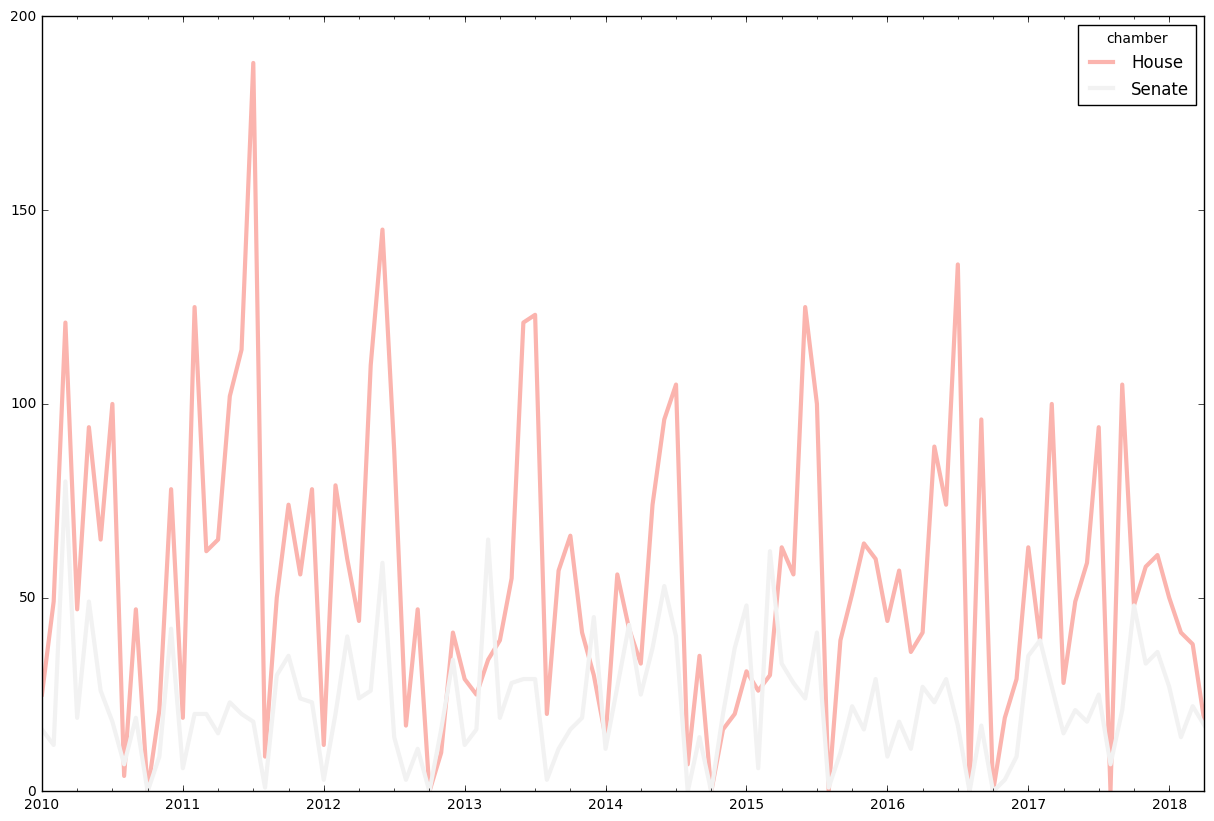

In [44]:
pvt = pd.DataFrame(vote_data).pivot_table(index='date',
                                    columns = 'chamber',
                                    aggfunc = 'count')['url']
pvt.index = pvt.index.to_datetime()
pvt = pvt.resample('m').sum().fillna(0)
pvt.tail(100).plot( # Plot number of votes per month in last 100 months
    figsize=(15,10),
    lw=3,
    colormap='Pastel1'
                  )

In [45]:
# compare
congress.members.compare('S000033','C001098','senate',congress=congress_meeting)

{'agree_percent': 16.15,
 'chamber': 'Senate',
 'common_votes': 384,
 'congress': '115',
 'disagree_percent': 83.85,
 'disagree_votes': 322,
 'first_member_api_uri': 'https://api.propublica.org/congress/v1/members/S000033.json',
 'first_member_id': 'S000033',
 'second_member_api_uri': 'https://api.propublica.org/congress/v1/members/C001098.json',
 'second_member_id': 'C001098'}

In [46]:
# passed bills
pd.DataFrame(congress.bills.passed('senate')['bills']).tail(3)

,active,bill_id,bill_slug,bill_type,bill_uri,committee_codes,committees,congressdotgov_url,cosponsors,cosponsors_by_party,...,sponsor_name,sponsor_party,sponsor_state,sponsor_title,sponsor_uri,subcommittee_codes,summary,summary_short,title,vetoed
17,True,s2040-115,s2040,s,https://api.propublica.org/congress/v1/115/bil...,[SSGA],Senate Homeland Security and Governmental Affa...,https://www.congress.gov/bill/115th-congress/s...,1,{'R': 1},...,Pat Roberts,R,KS,Sen.,https://api.propublica.org/congress/v1/members...,[],Designates the facility of the United States P...,Designates the facility of the United States P...,A bill to designate the facility of the United...,None
18,True,s2030-115,s2030,s,https://api.propublica.org/congress/v1/115/bil...,"[HSIF, SSEG]",House Energy and Commerce Committee,https://www.congress.gov/bill/115th-congress/s...,3,"{'D': 2, 'R': 1}",...,Thom Tillis,R,NC,Sen.,https://api.propublica.org/congress/v1/members...,"[HSIF03, SSEG01]",Ceiling Fan Energy Conservation Harmonization ...,Ceiling Fan Energy Conservation Harmonization ...,A bill to deem the compliance date for amended...,None
19,True,hr3731-115,hr3731,hr,https://api.propublica.org/congress/v1/115/bil...,"[SSJU, HSGO, HSJU]",Senate Judiciary Committee,https://www.congress.gov/bill/115th-congress/h...,15,"{'D': 5, 'R': 10}",...,John Katko,R,NY,Rep.,https://api.propublica.org/congress/v1/members...,[HSJU08],Secret Service Recruitment and Retention Act o...,Secret Service Recruitment and Retention Act o...,To provide overtime pay for employees of the U...,None
